# Análisis exploratorio de los datos

El objetivo de este notebook es analalizar los distitnos datos obtenidos en la etapa anterior. Trataremos de analizar cada una de las características generados así como las distribuciones que siguen para cada una de las clases. Esto nos servirá como indicativo de qué características serán representativas para el posterior entrenamiento de modelos de machine learning.

In [5]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [6]:
# Funciones de extracción de características
def amplitude_envelope(signal, frame_size=1024, hop_length=512):
    return np.array([max(signal[i:i+frame_size]) for i in range(0, len(signal), hop_length)])

def calculate_ber(signal, split_freq, sample_rate, frame_size=1024, hop_length=512):
    spec = librosa.stft(signal, n_fft=frame_size, hop_length=hop_length)
    freq_per_bin = sample_rate / 2 / spec.shape[0]
    split_bin = int(split_freq / freq_per_bin)
    spec_magnitude = np.abs(spec).T

    ber = []
    for freqs in spec_magnitude:
        low_energy = np.sum(freqs[:split_bin]**2)
        high_energy = np.sum(freqs[split_bin:]**2)
        ber.append(low_energy / high_energy if high_energy != 0 else 0)
    return np.array(ber)

# Carga de datos de anotaciones
df = pd.read_csv('ccmusic2/validation/annotations.csv')
features = []

# Análisis de todos los archivos de audio
audio_files = os.listdir('ccmusic2/validation/audios/')
for file_name in audio_files:
    audio_path = f'ccmusic2/validation/audios/{file_name}'
    audio_data, sr = librosa.load(audio_path, sr=None)
    label = df[df['audio_file'] == int(file_name.split('.')[0])]['label_name'].values[0]

    # Extracción de características
    envelope = amplitude_envelope(audio_data)
    rms = librosa.feature.rms(y=audio_data)
    zcr = librosa.feature.zero_crossing_rate(audio_data)
    ber = calculate_ber(audio_data, 500, sr)
    spec_cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)

    features.append({
        "file": file_name,
        "label": label,
        "rms": np.mean(rms),
        "zcr": np.mean(zcr),
        "ber": np.mean(ber),
        "spec_cent": np.mean(spec_cent),
        "spec_bw": np.mean(spec_bw),
        "chroma_stft": np.mean(chroma_stft),
        "rolloff": np.mean(rolloff),
        "mfcc": np.mean(mfcc)
    })


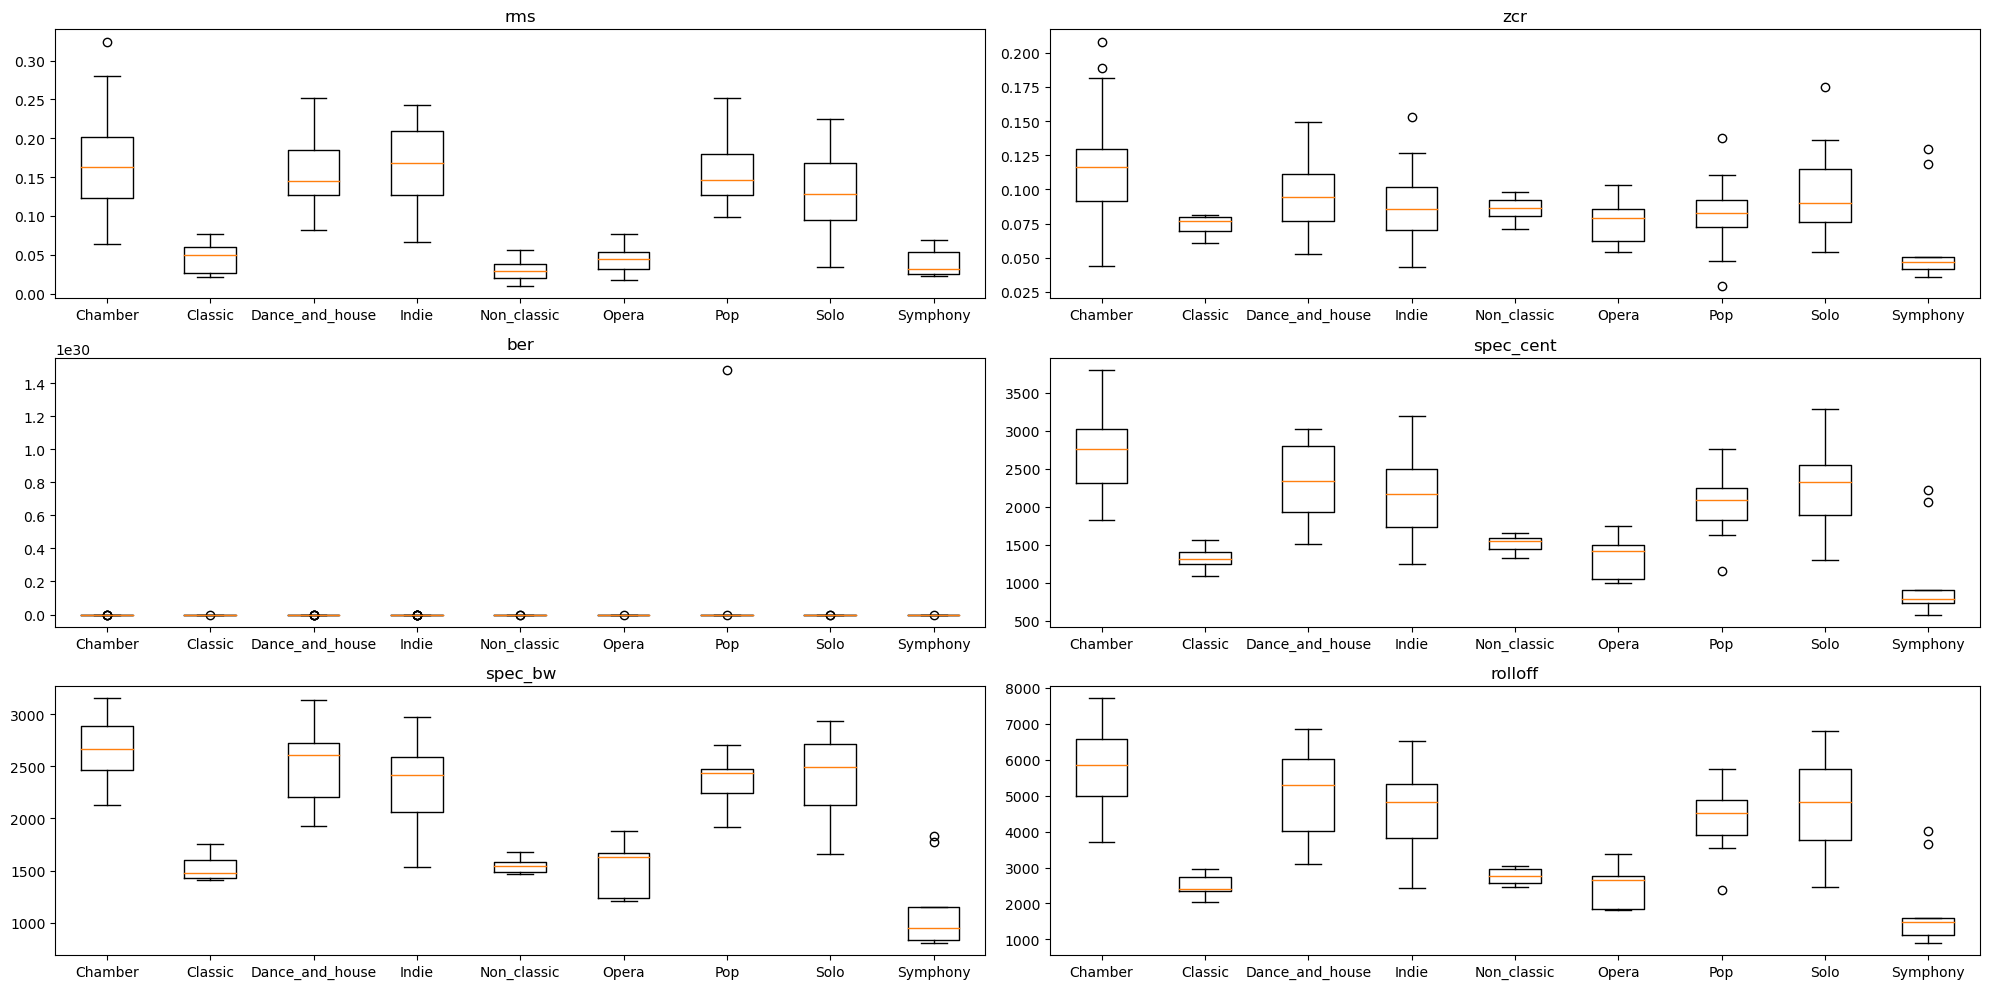

In [8]:
# Convertir a DataFrame para análisis posterior
features_df = pd.DataFrame(features)

# Gráficos de caja y bigote para todas las características
plt.figure(figsize=(20, 10))
for i, feature_name in enumerate(['rms', 'zcr', 'ber', 'spec_cent', 'spec_bw', 'rolloff'], 1):
    plt.subplot(3, 2, i)
    boxplot_data = [group[feature_name].values for name, group in features_df.groupby('label')]
    plt.boxplot(boxplot_data, labels=[name for name, _ in features_df.groupby('label')])
    plt.title(feature_name)
plt.tight_layout()
plt.show()

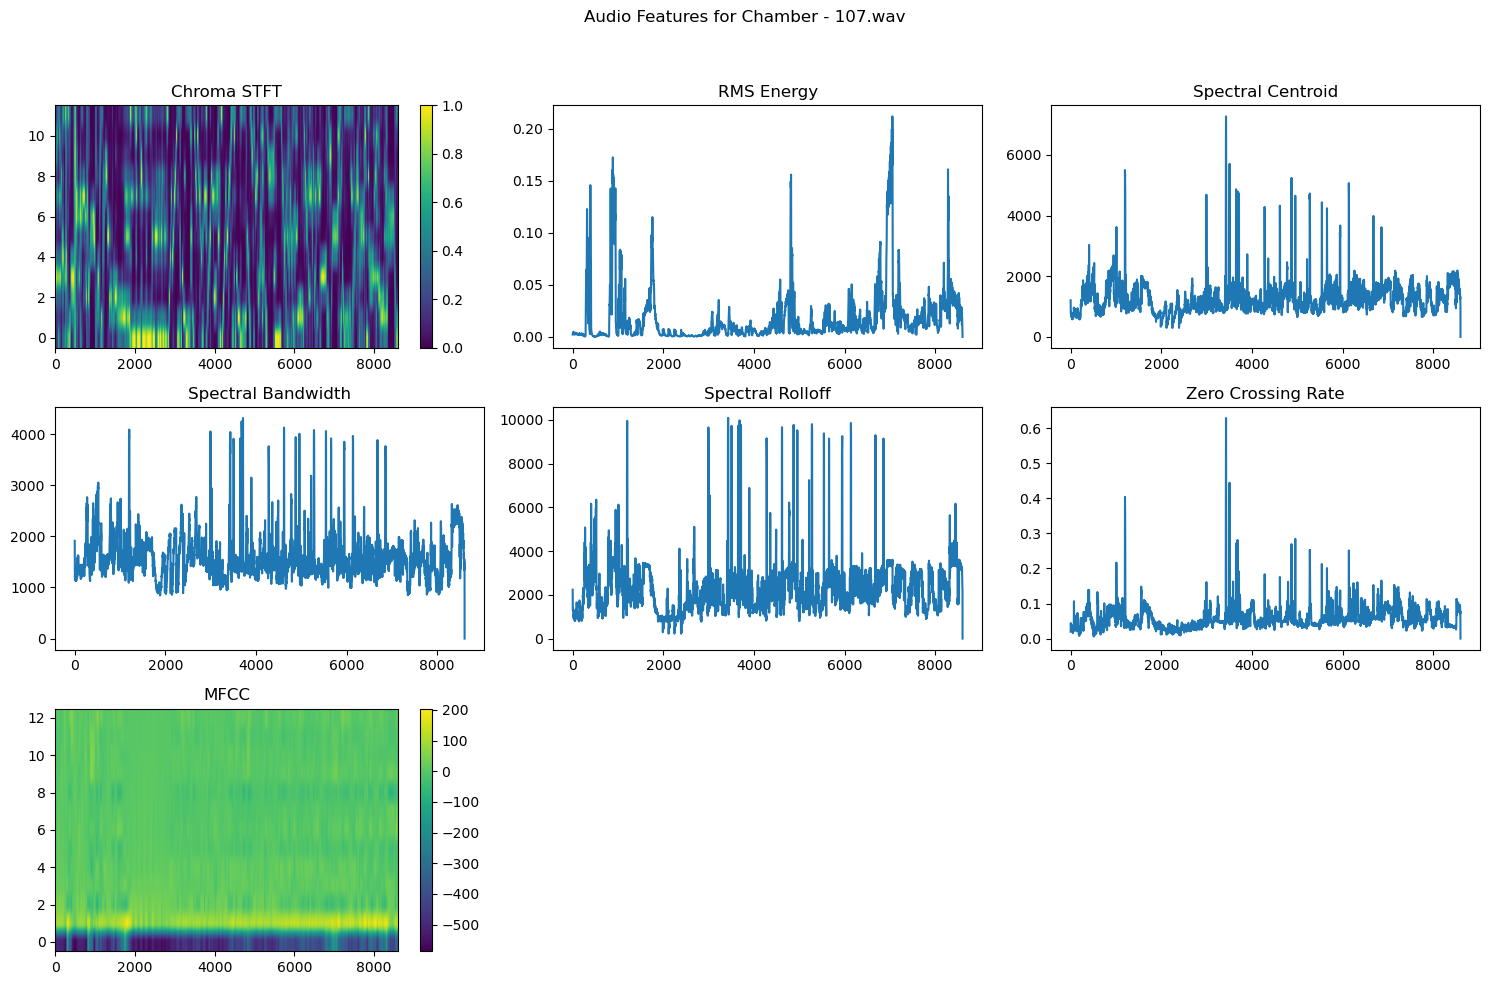

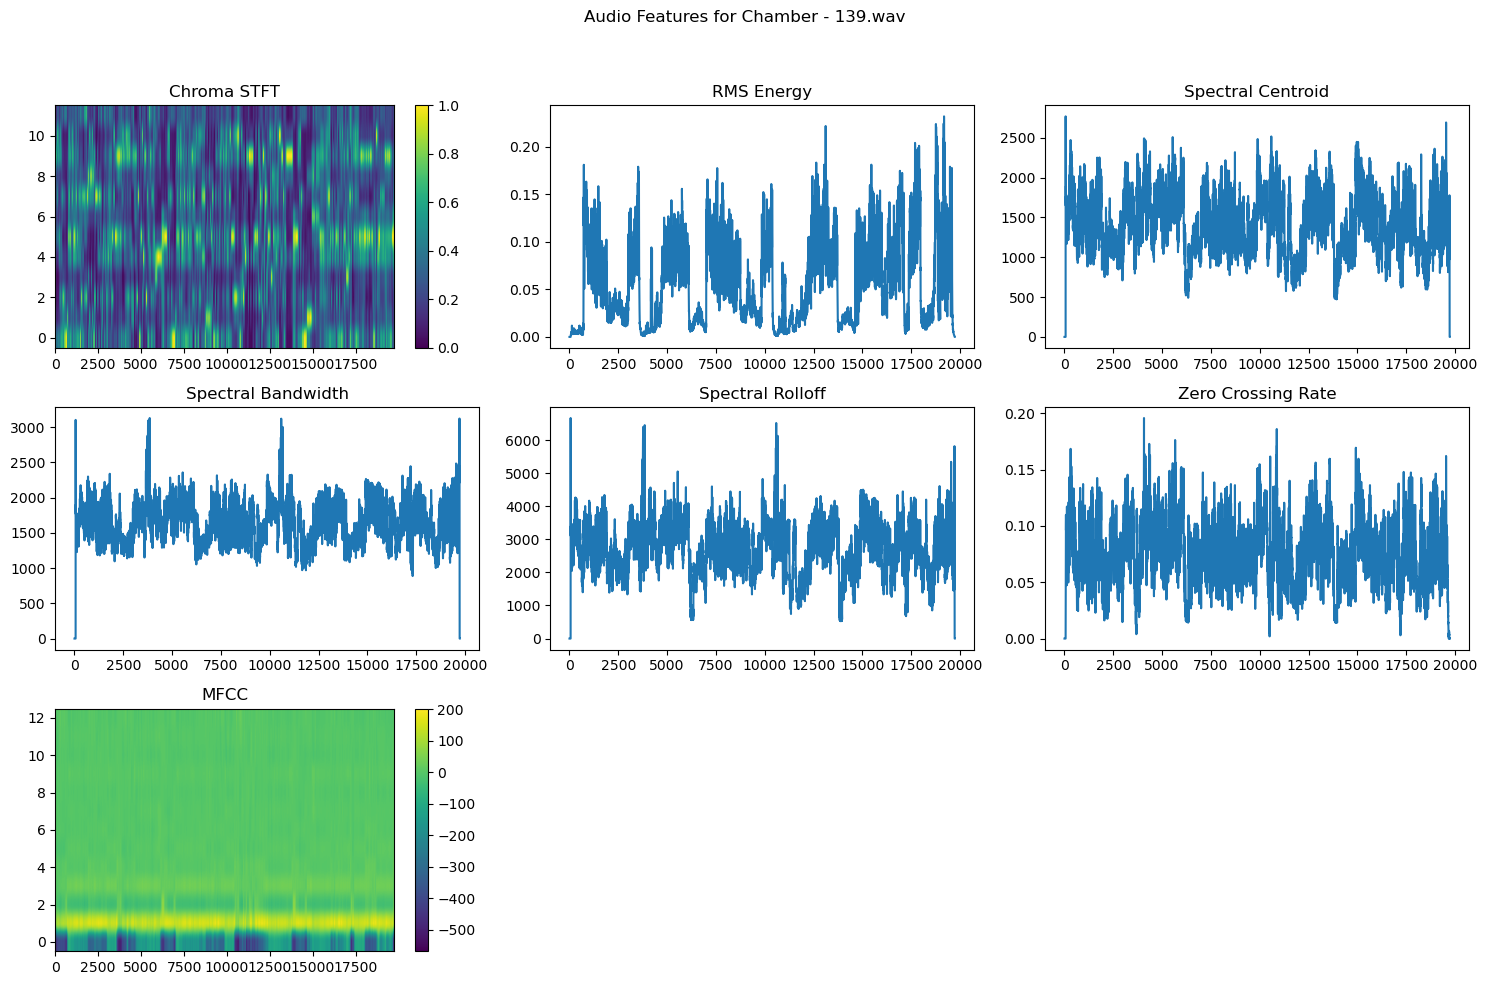

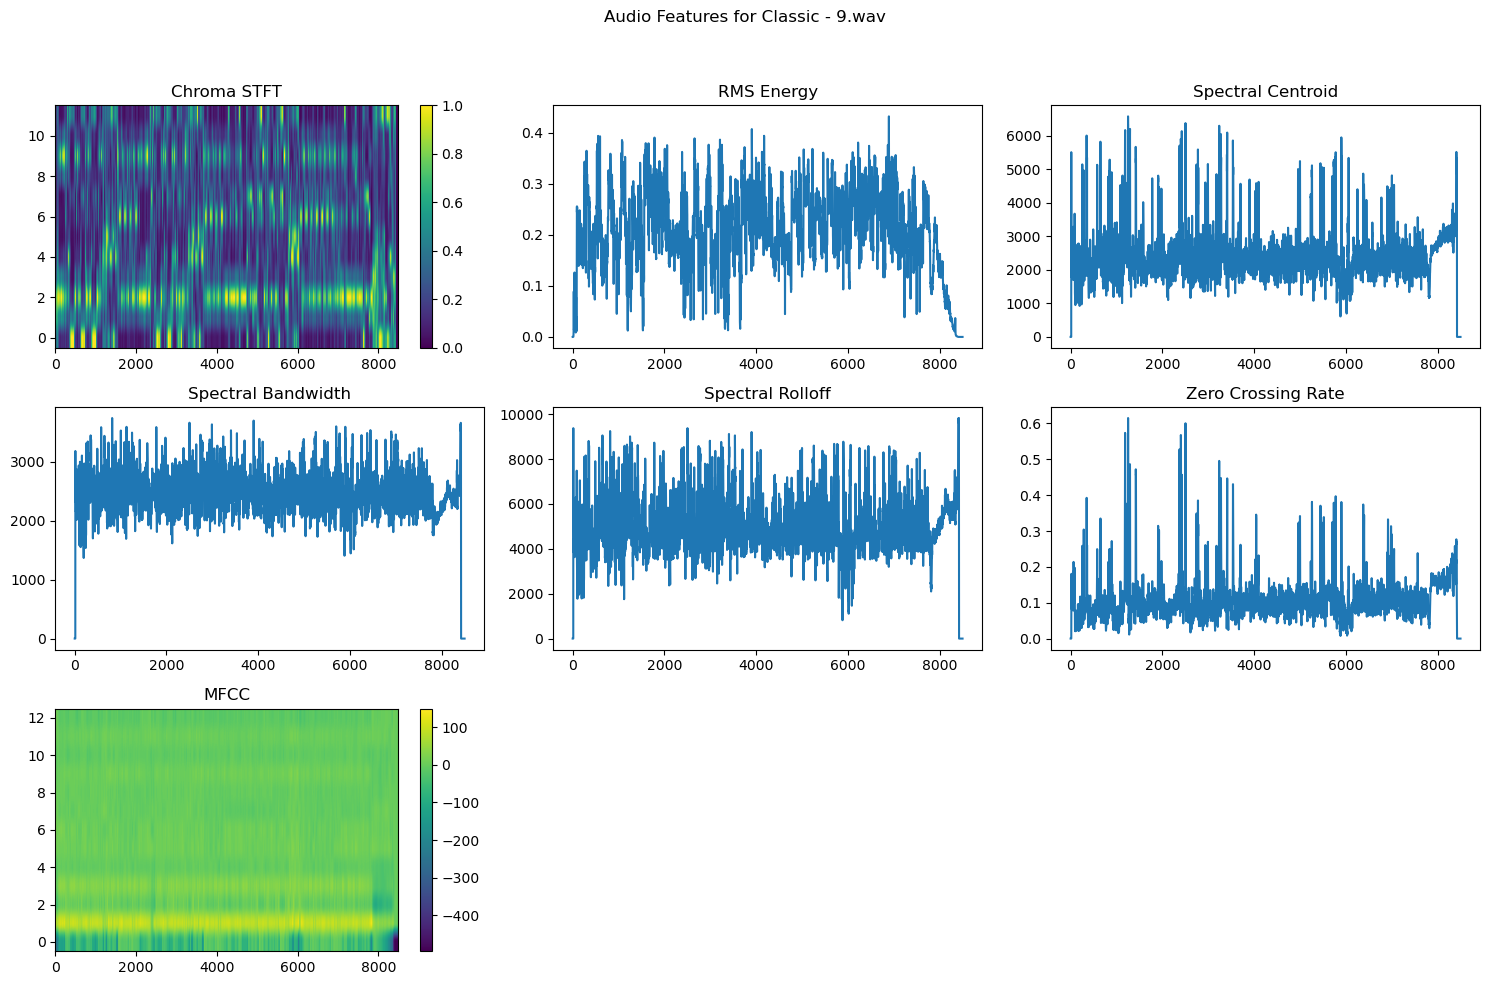

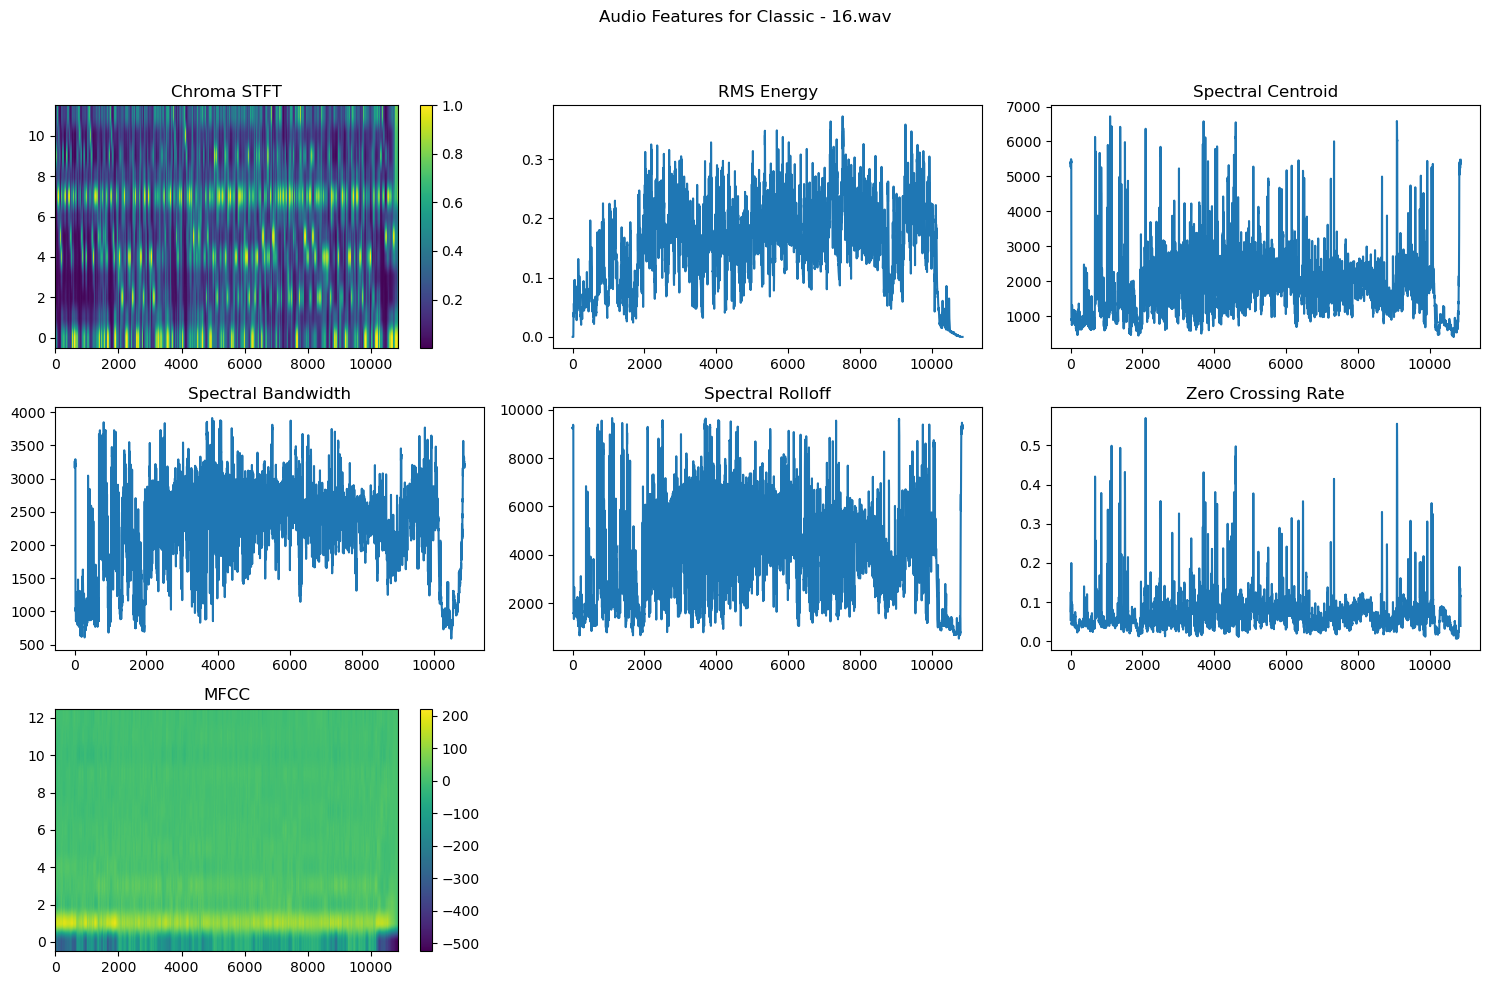

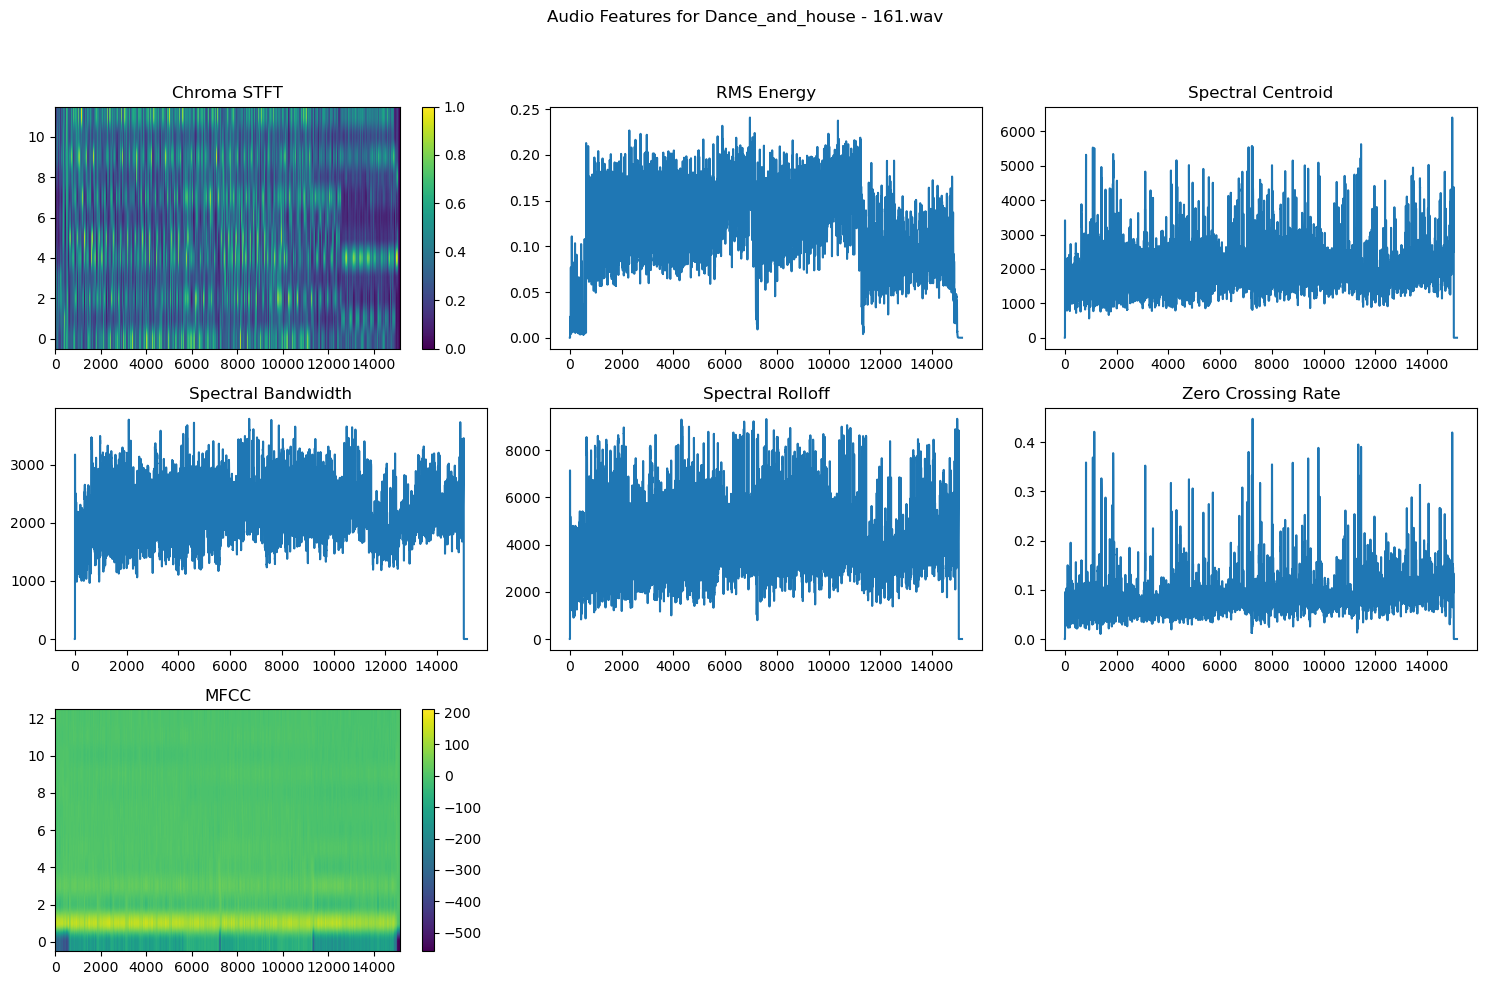

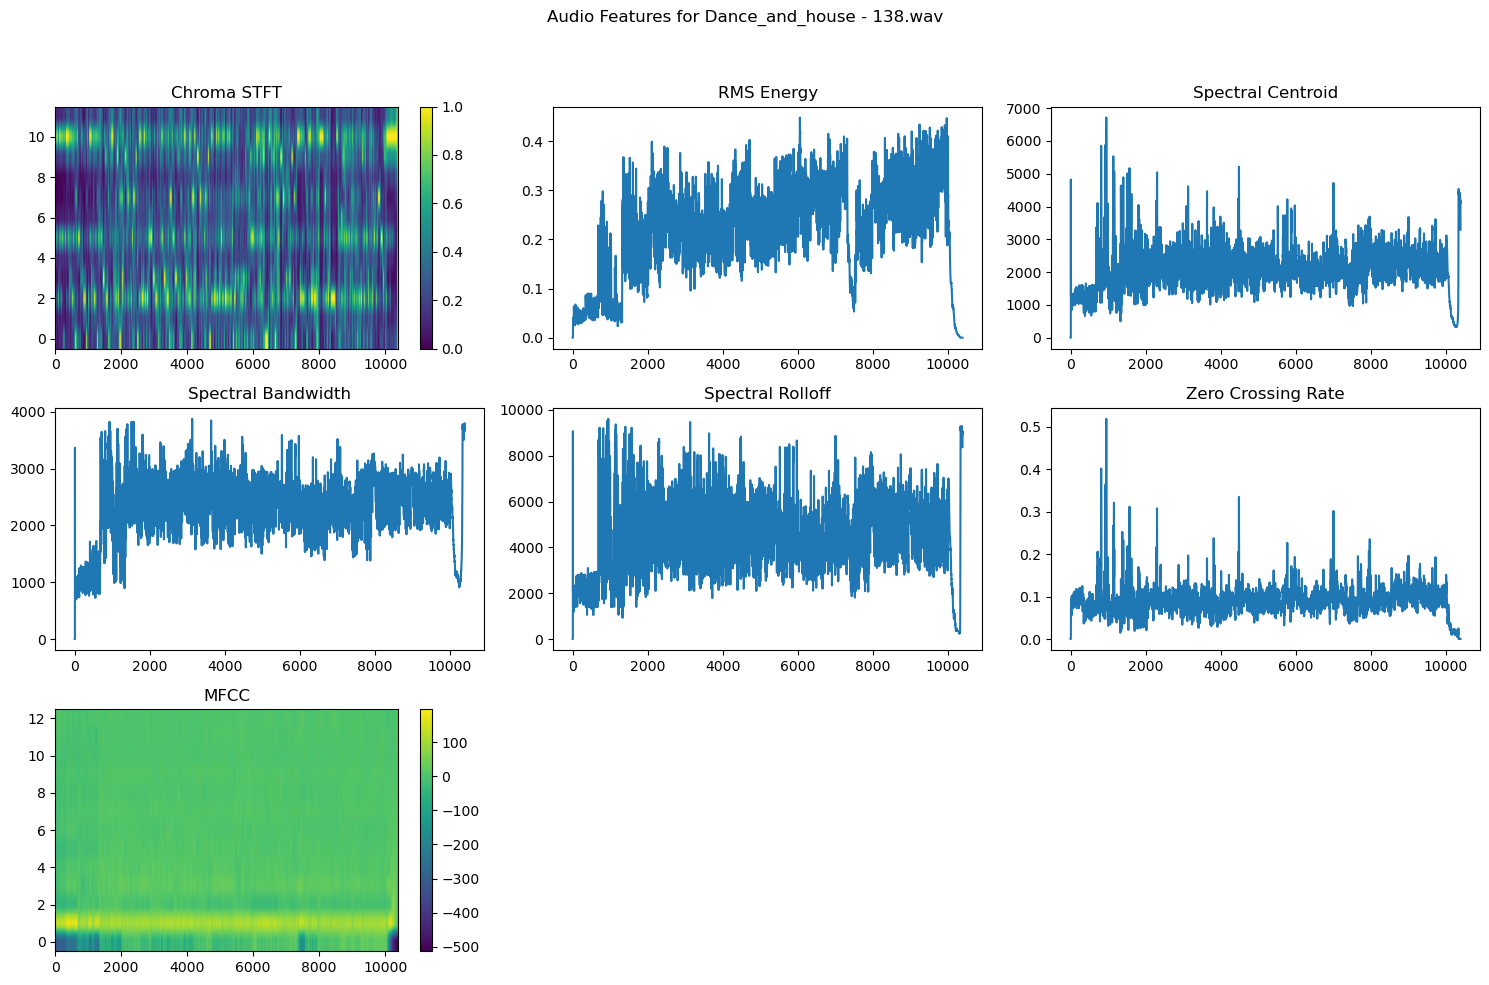

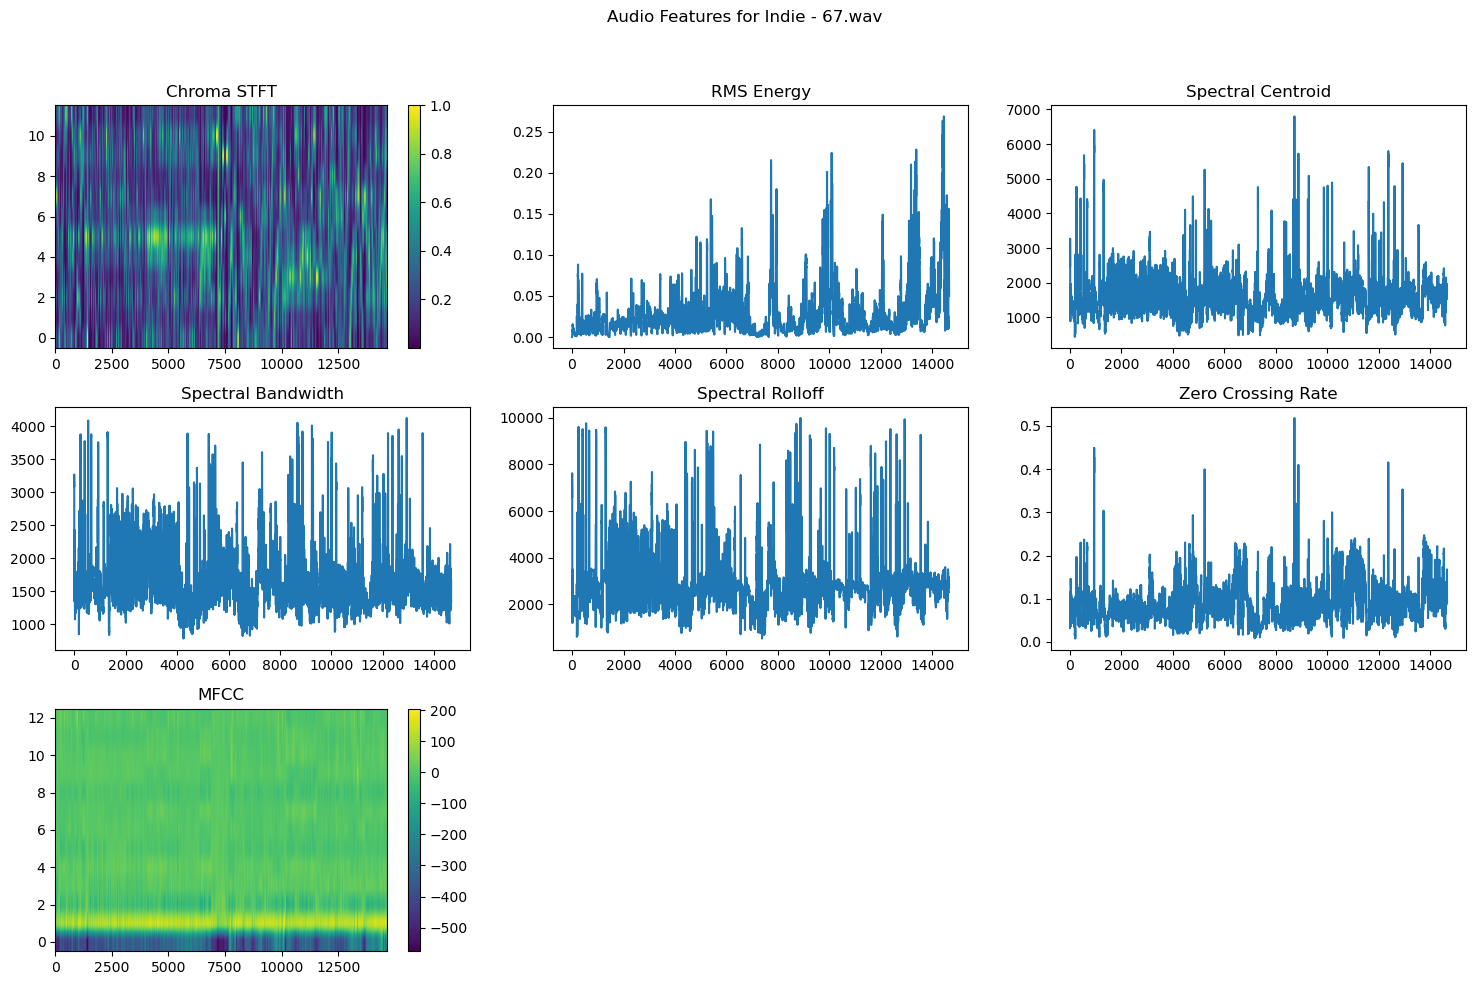

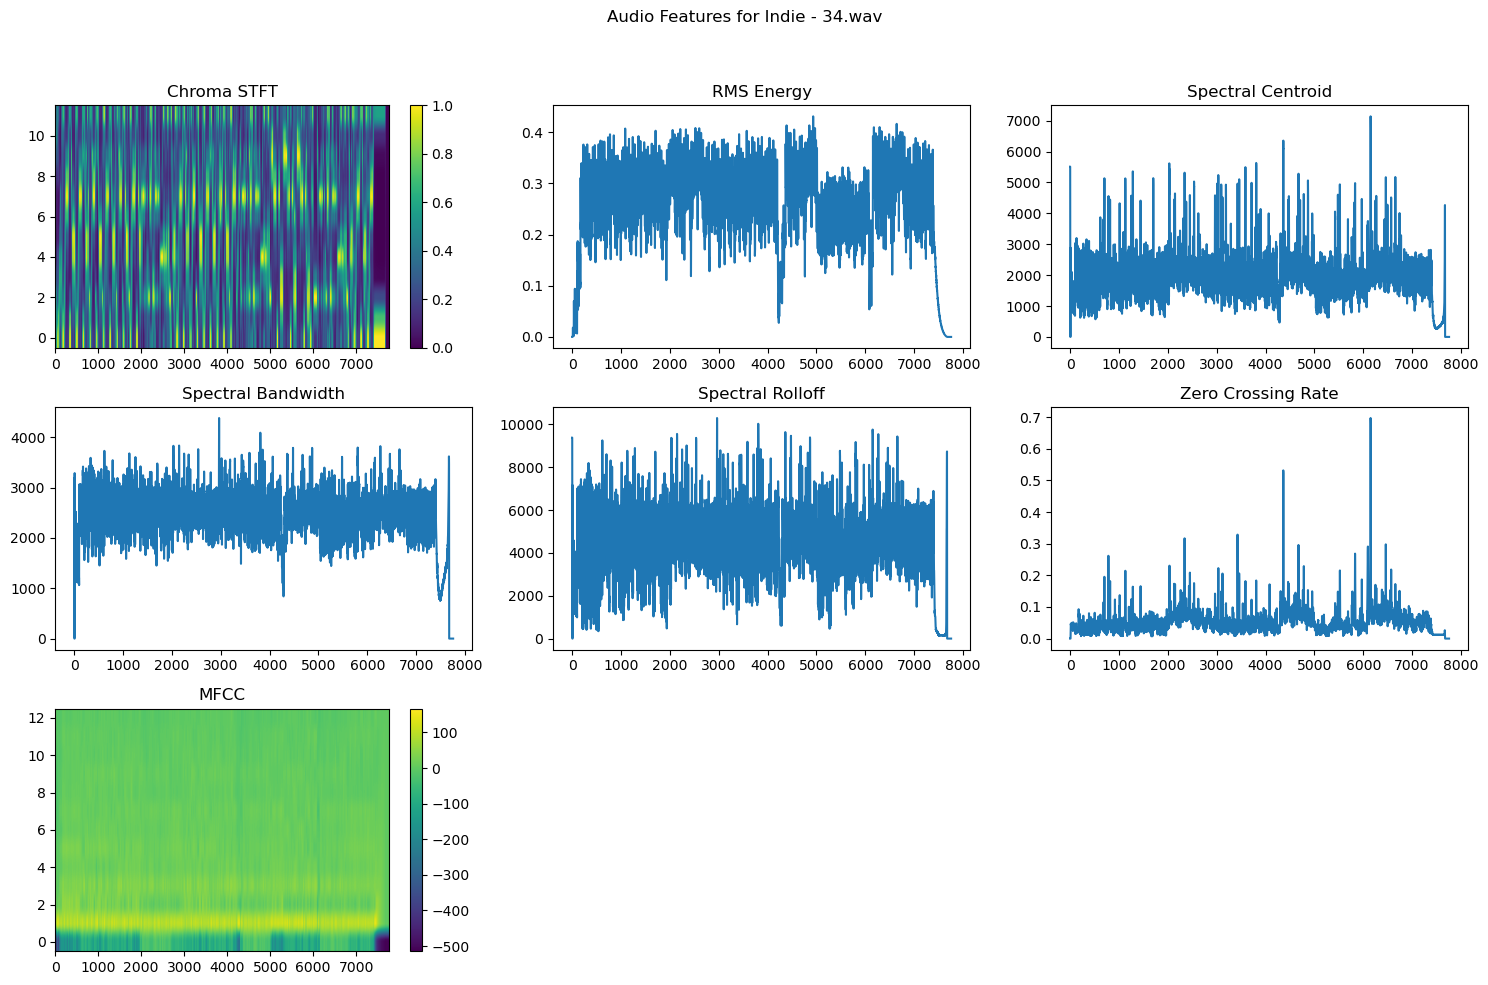

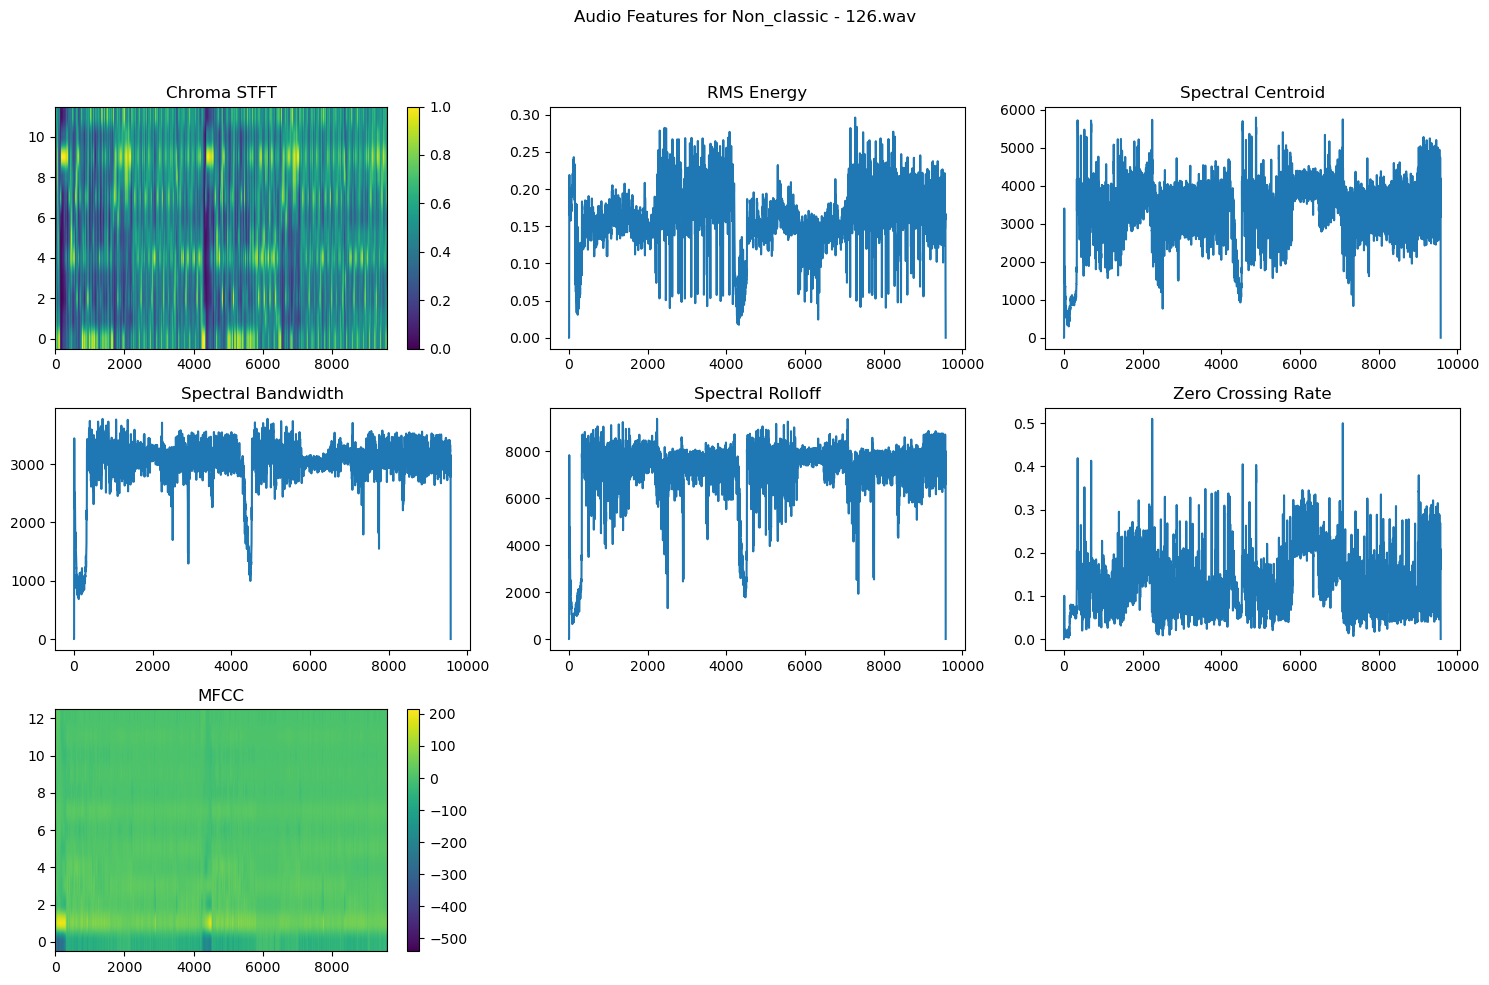

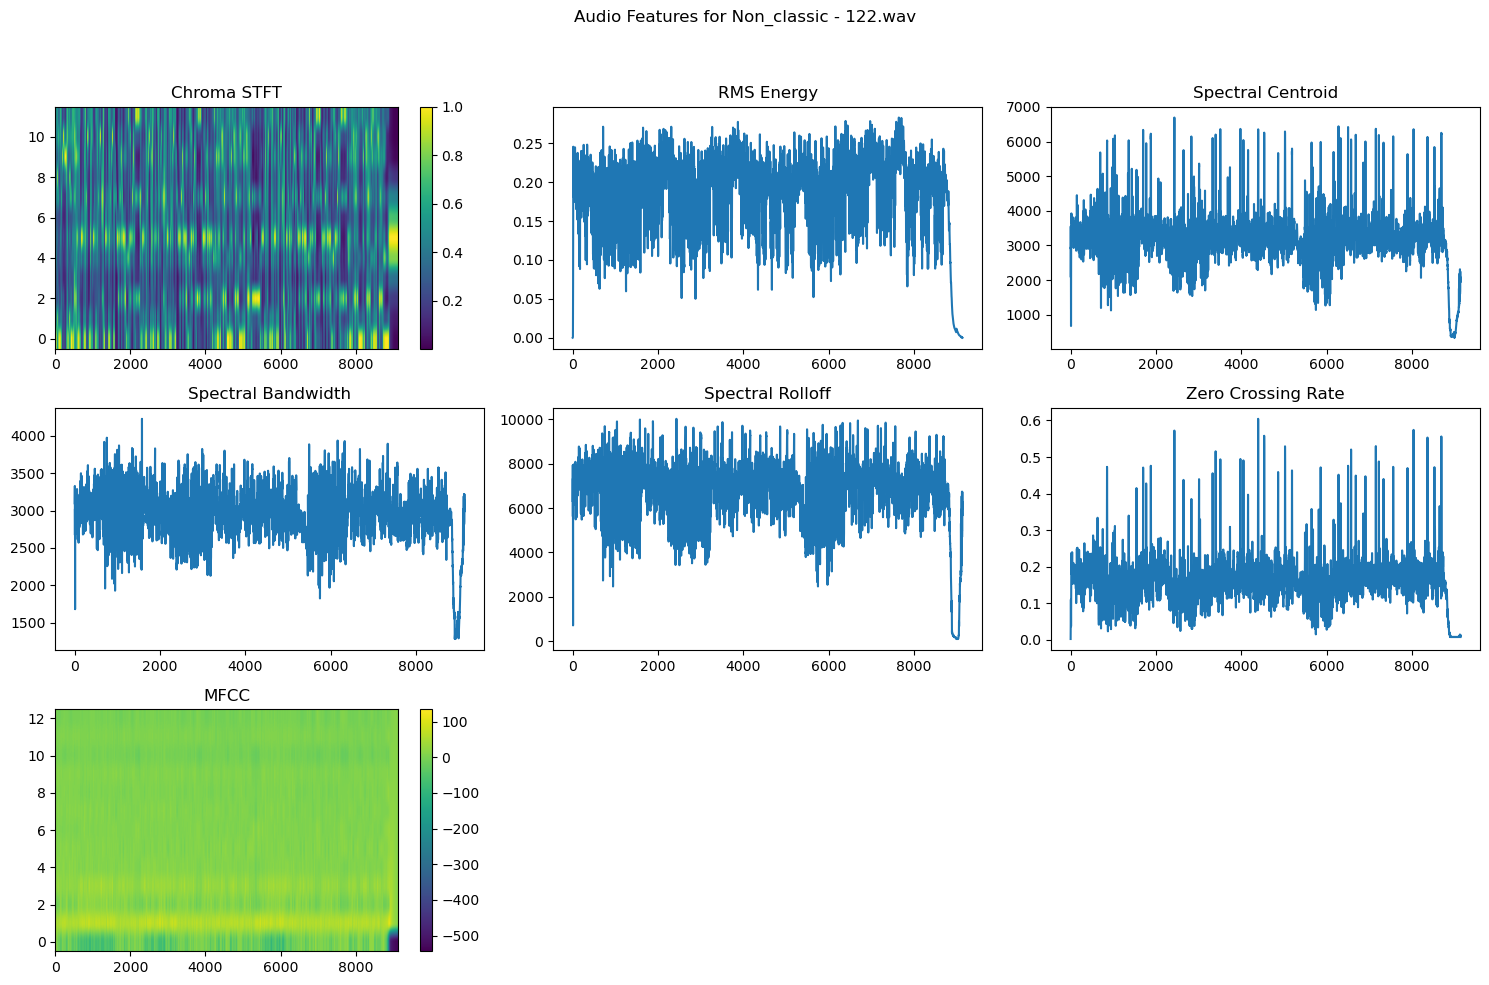

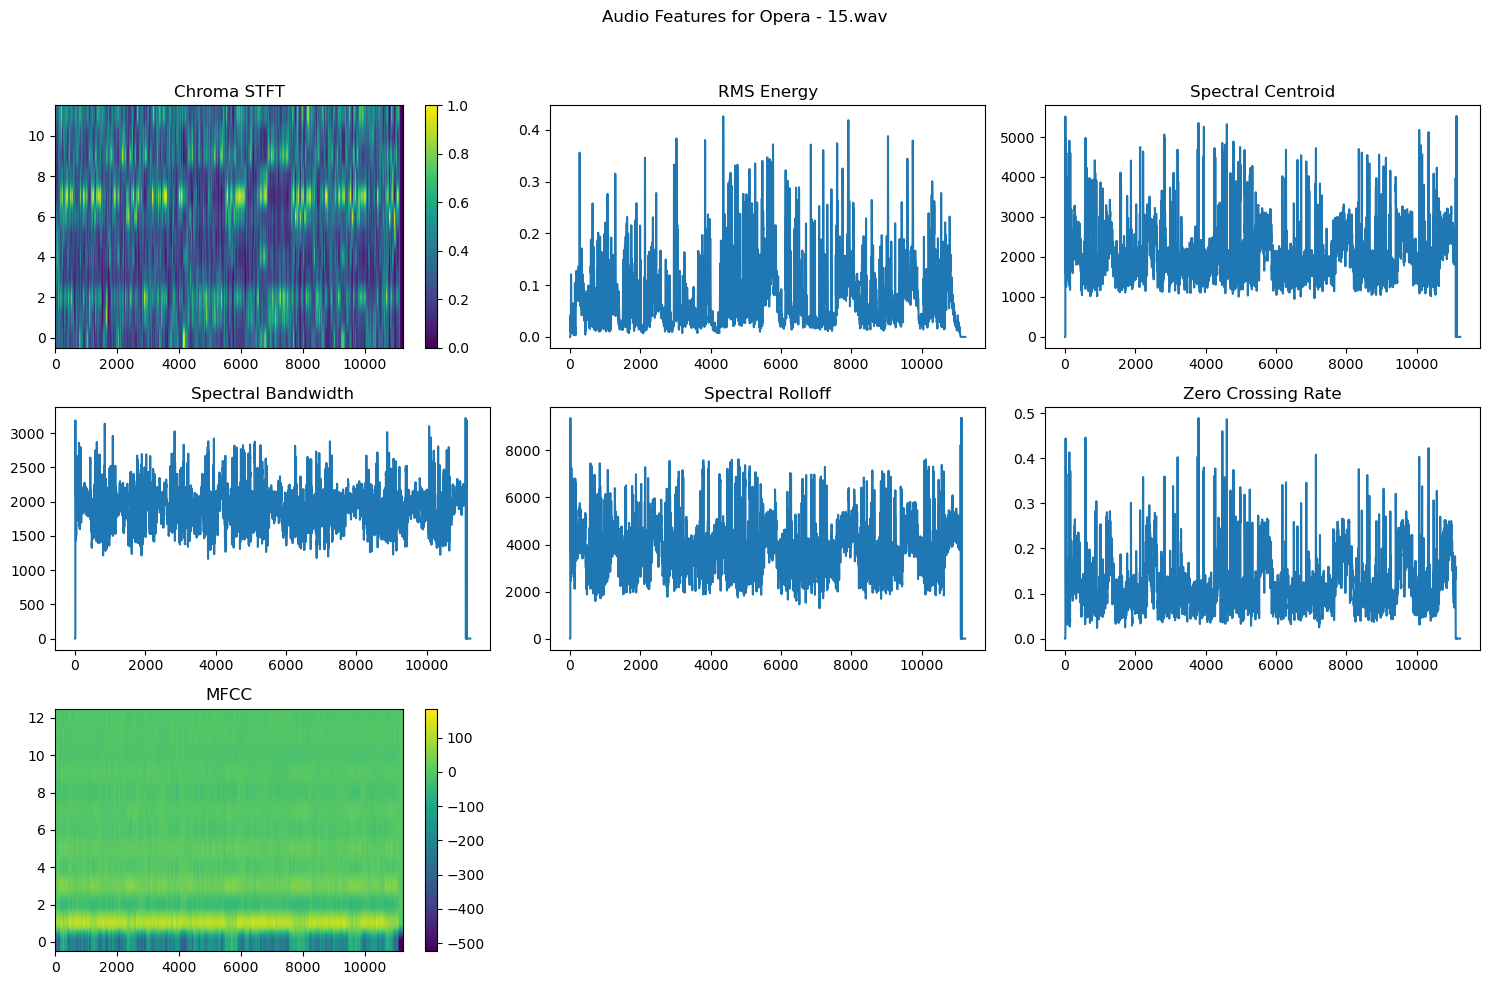

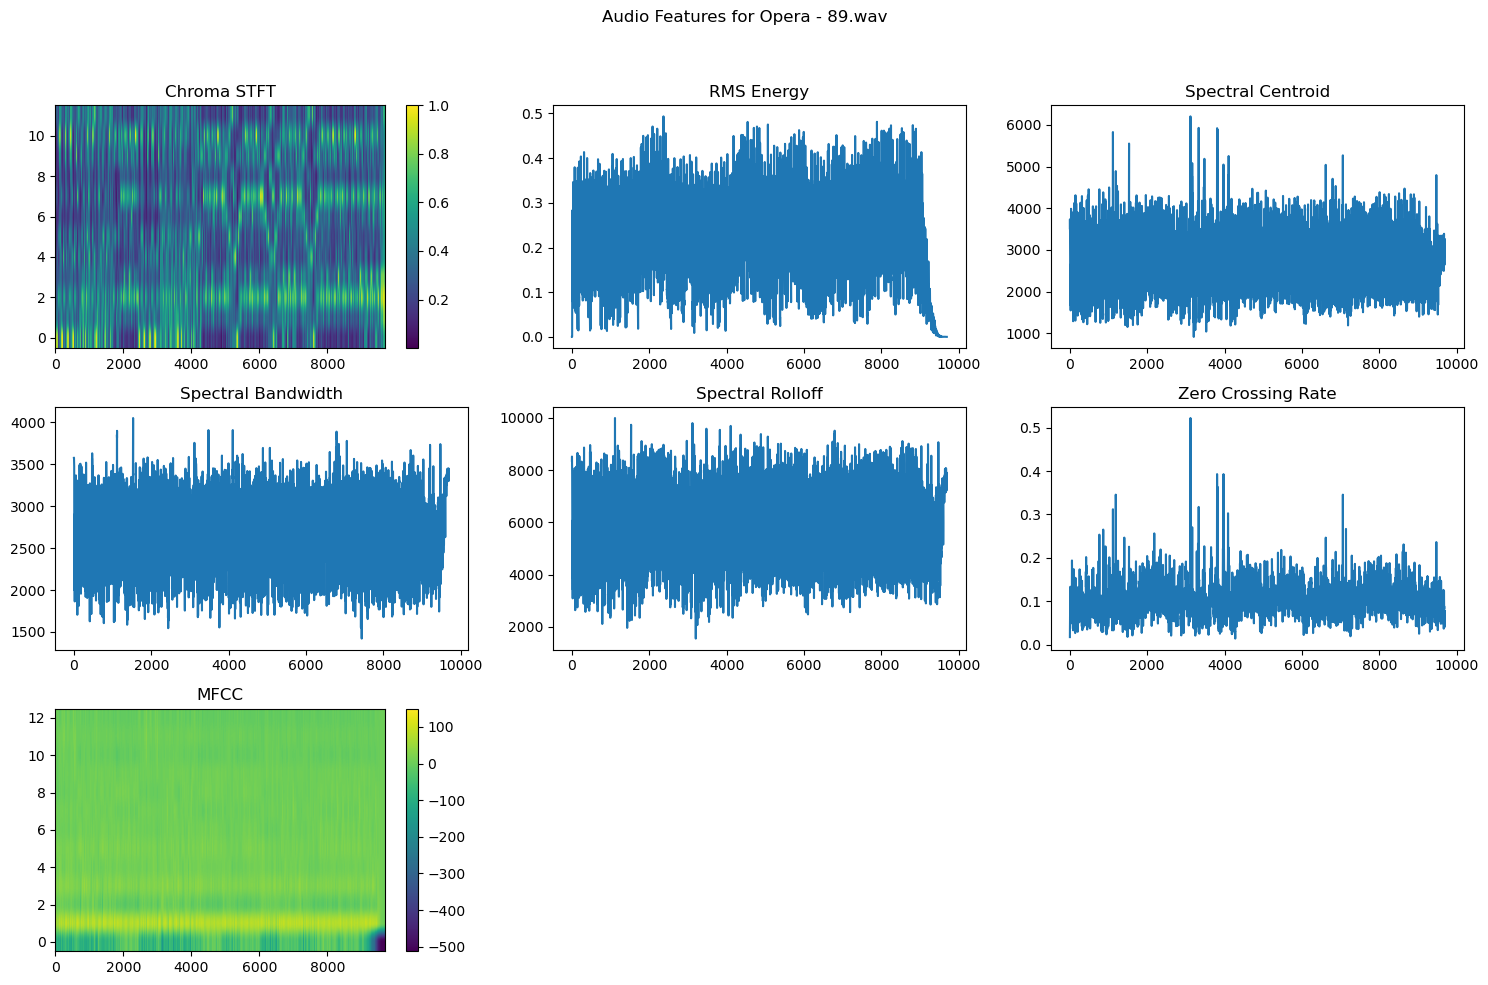

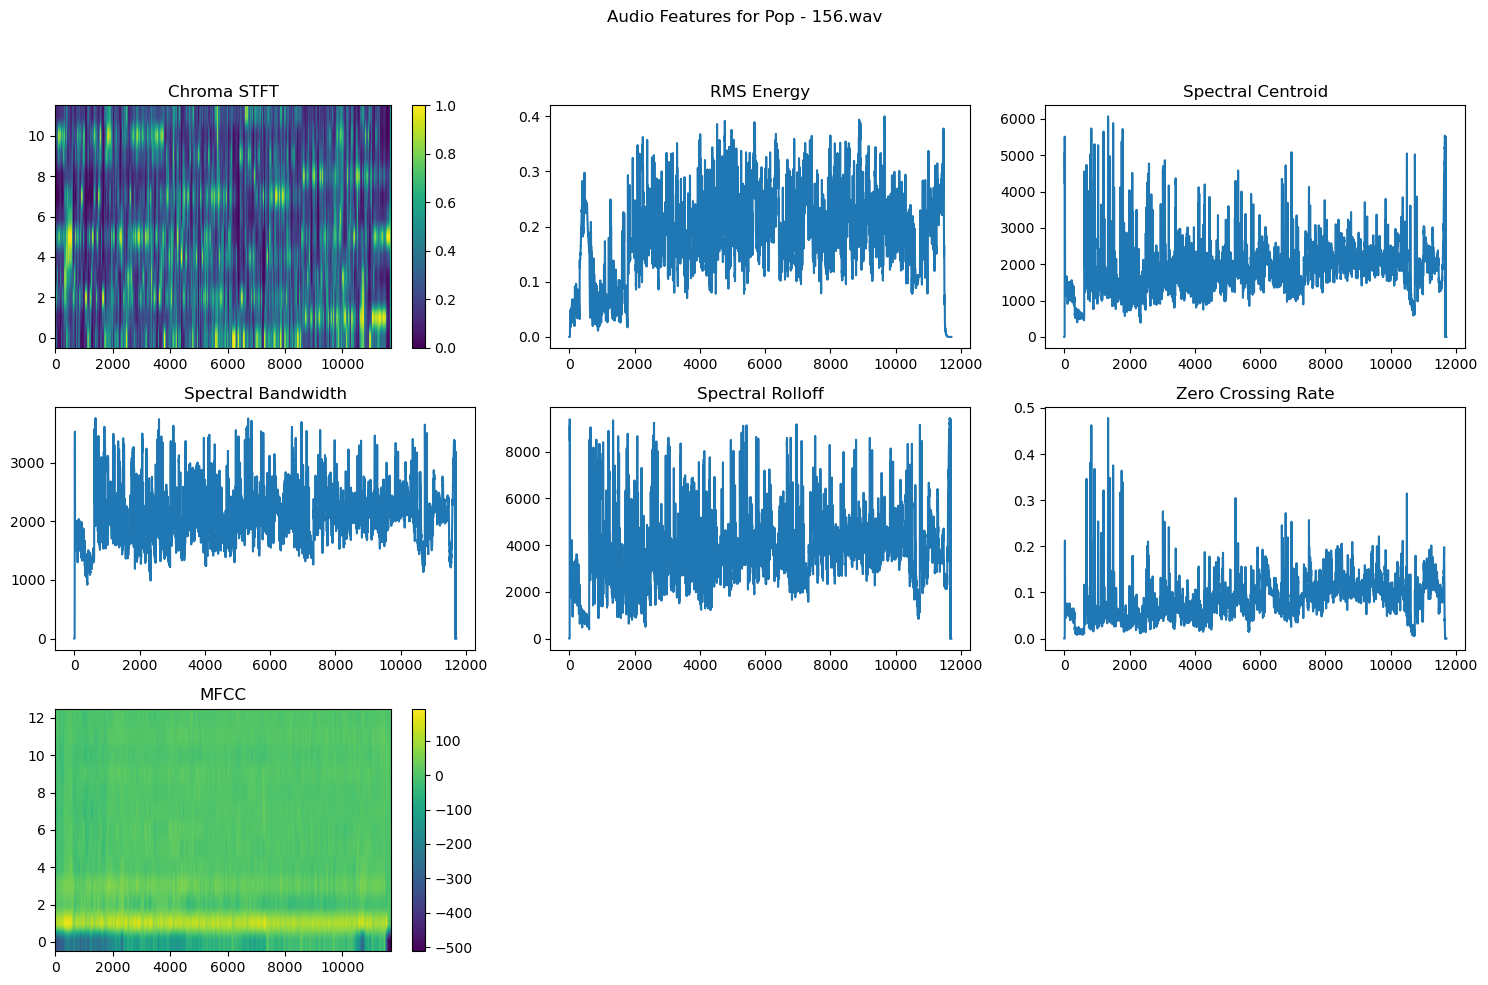

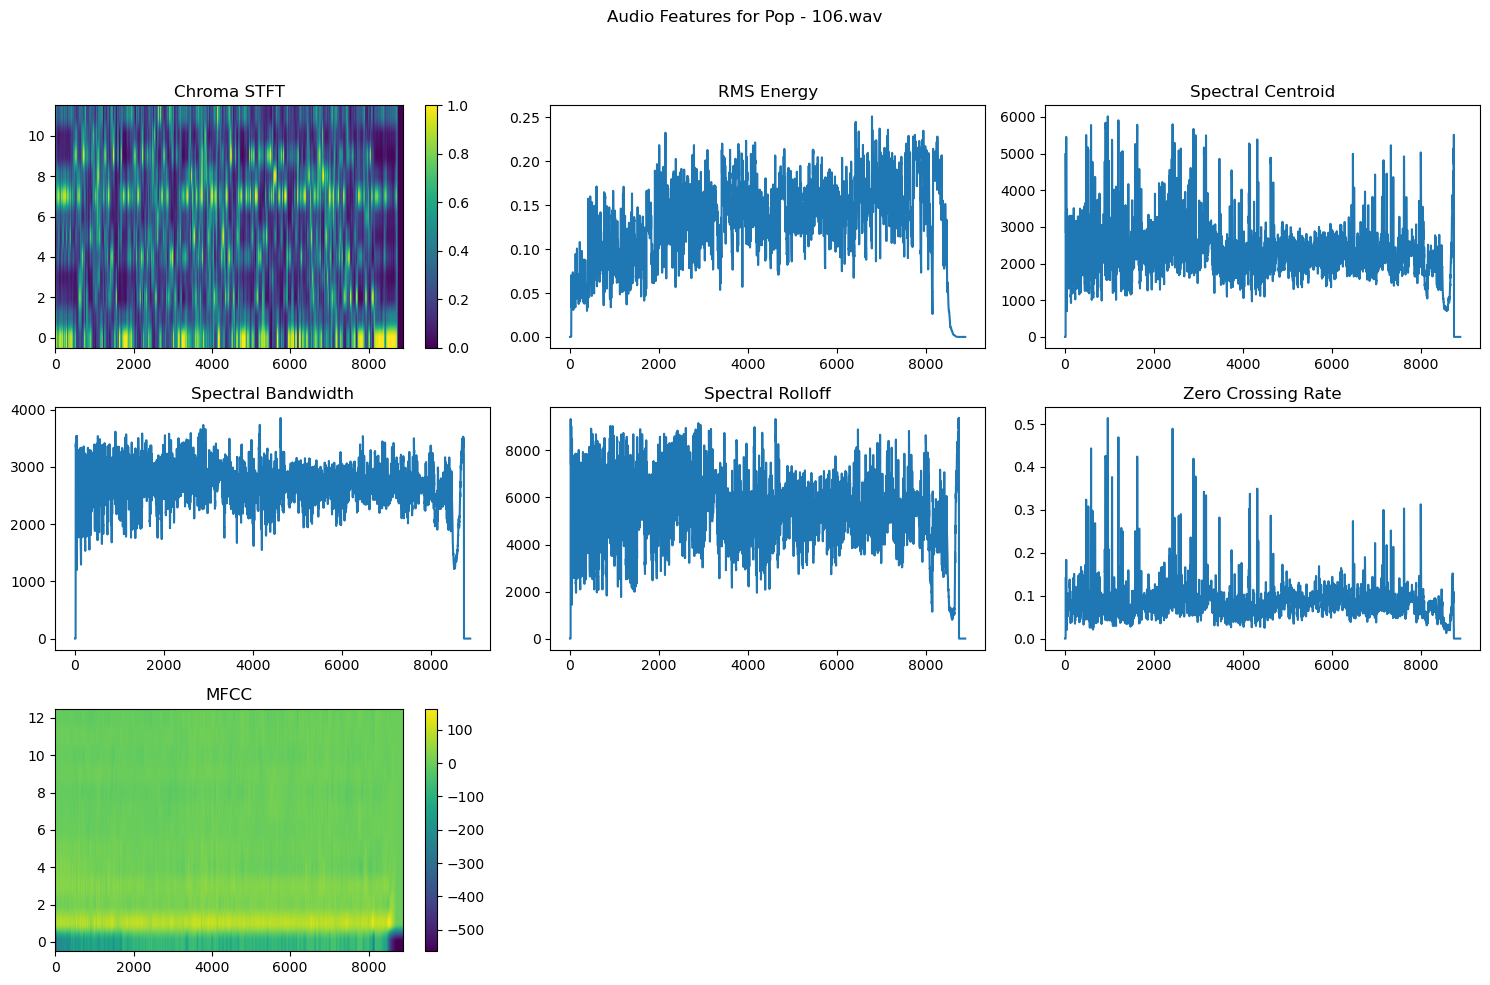

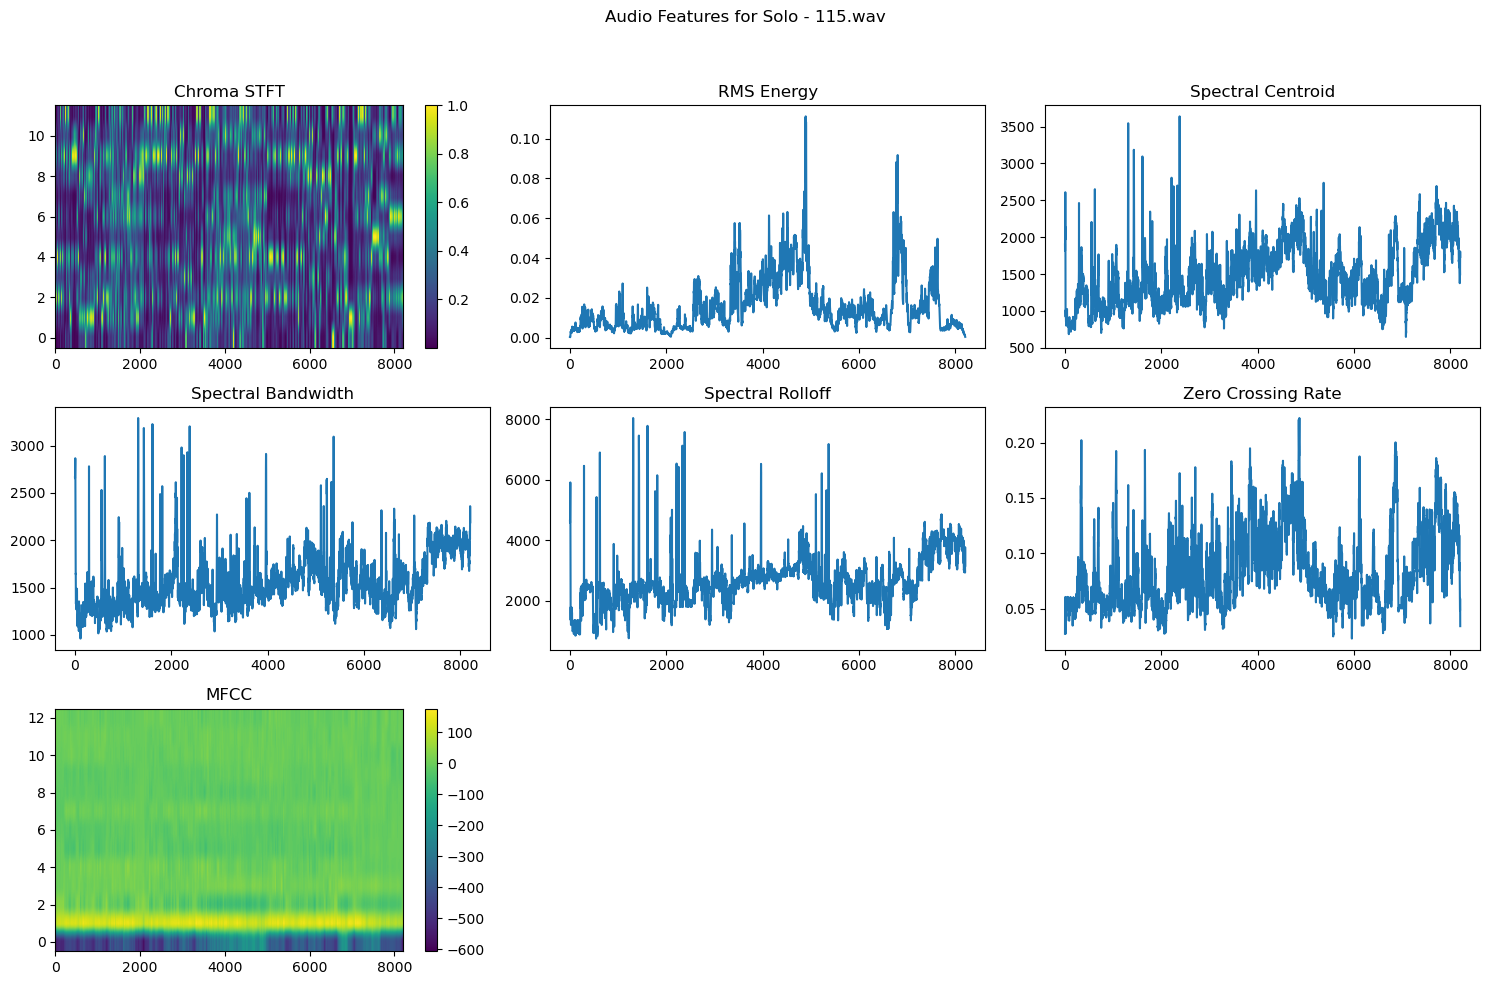

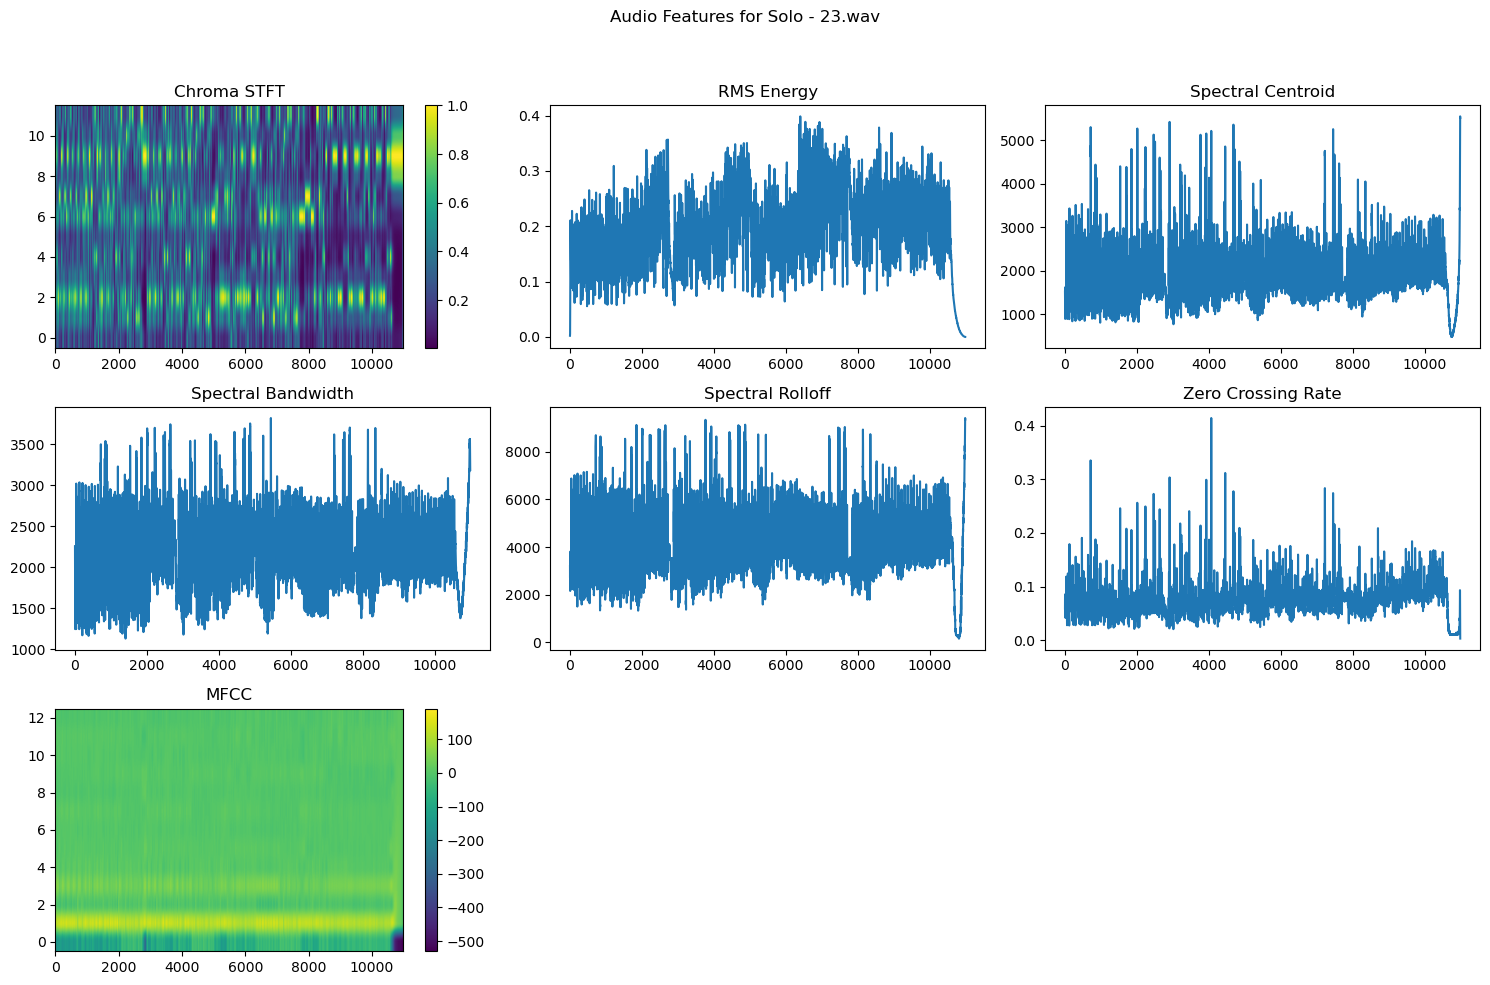

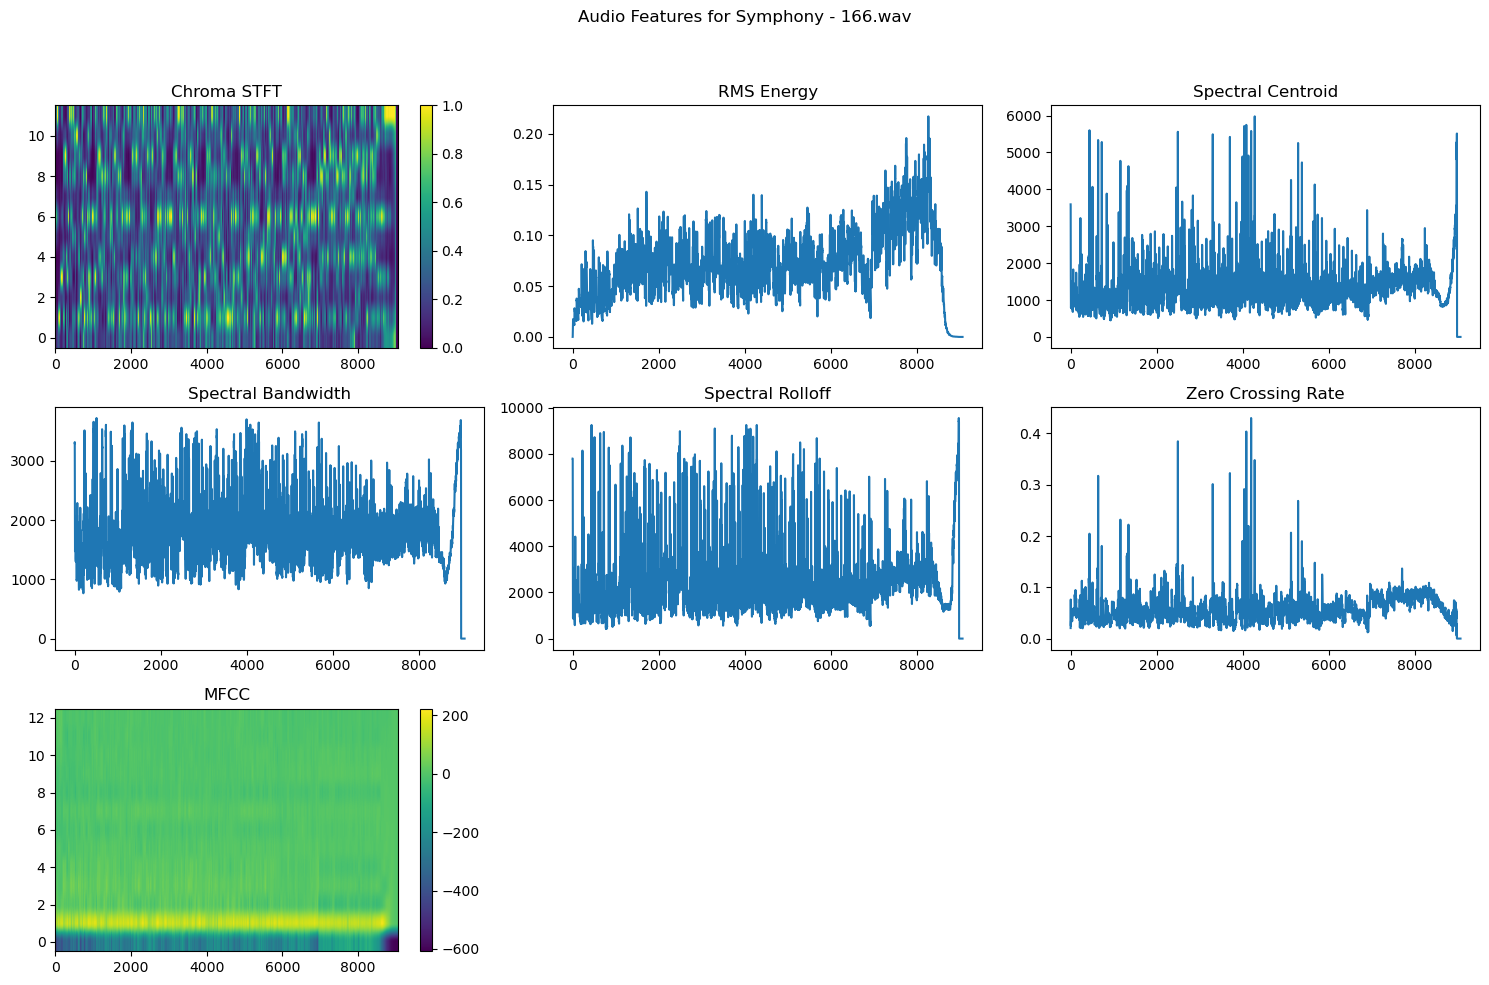

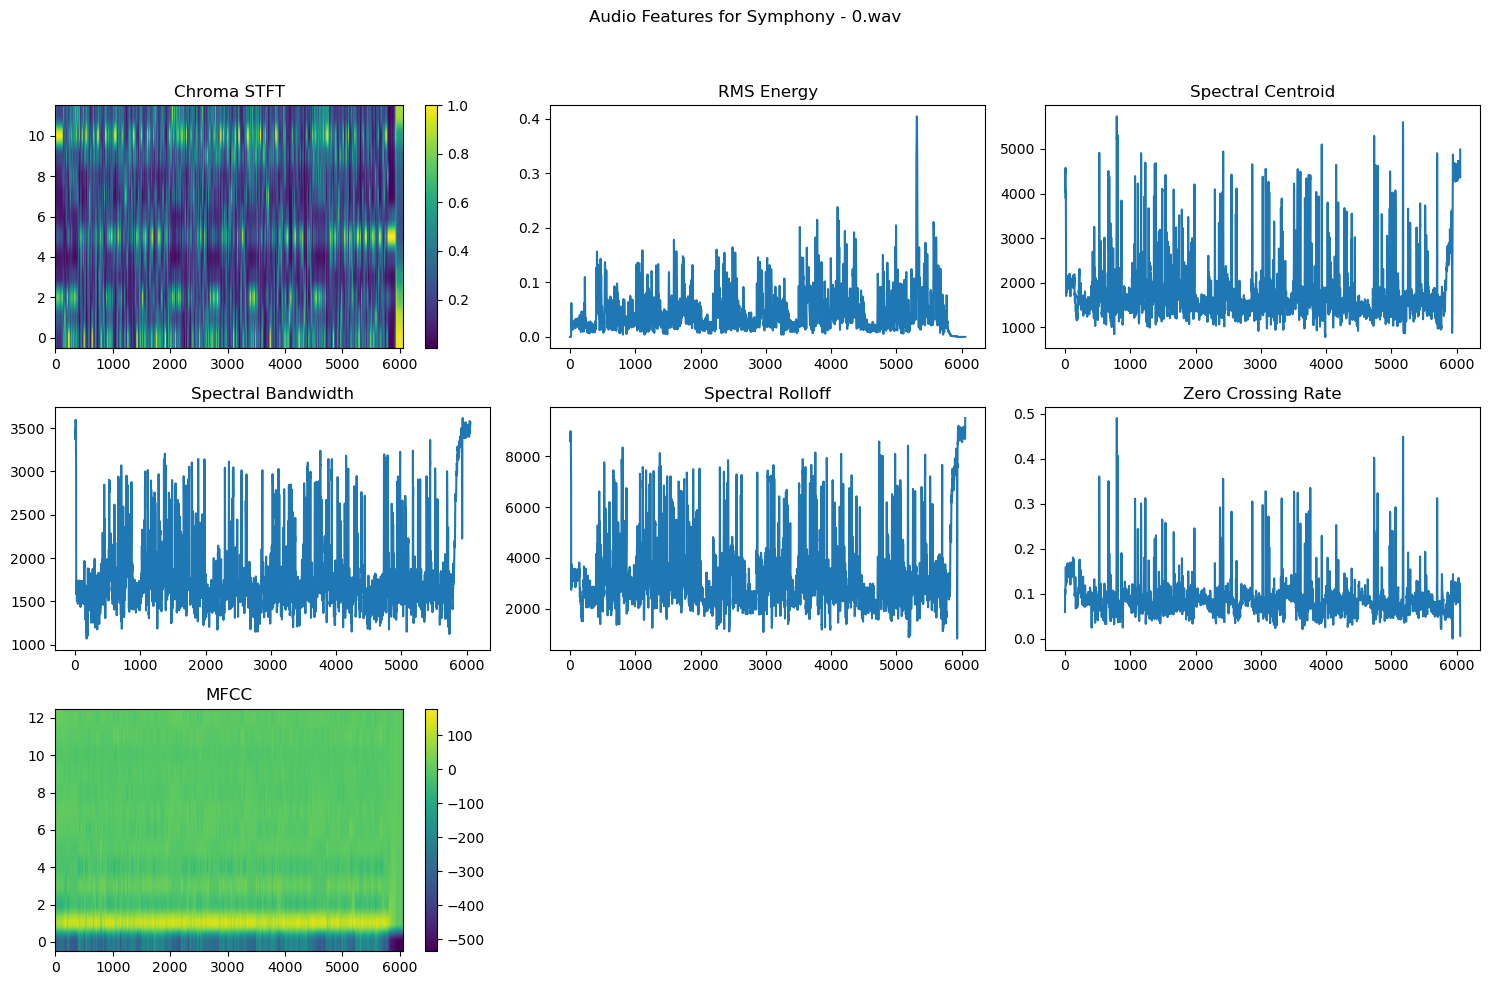

In [10]:
# Carga de datos de anotaciones y selección de dos audios por categoría
df = pd.read_csv('ccmusic2/validation/annotations.csv')
selected_files = df.groupby('label_name').apply(lambda x: x.sample(2)).reset_index(drop=True)

# Función para graficar las características del audio
def plot_audio_features(audio_path, sr, label):
    audio_data, sr = librosa.load(audio_path, sr=sr)

    # Extracción de características
    chroma_stft = librosa.feature.chroma_stft(y=audio_data, sr=sr)
    rms = librosa.feature.rms(y=audio_data)
    spec_cent = librosa.feature.spectral_centroid(y=audio_data, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y=audio_data)
    mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)

    # Visualización de características
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'Audio Features for {label} - {os.path.basename(audio_path)}')

    plt.subplot(3, 3, 1)
    plt.imshow(chroma_stft, aspect='auto', origin='lower')
    plt.title('Chroma STFT')
    plt.colorbar()

    plt.subplot(3, 3, 2)
    plt.plot(rms[0])
    plt.title('RMS Energy')

    plt.subplot(3, 3, 3)
    plt.plot(spec_cent[0])
    plt.title('Spectral Centroid')

    plt.subplot(3, 3, 4)
    plt.plot(spec_bw[0])
    plt.title('Spectral Bandwidth')

    plt.subplot(3, 3, 5)
    plt.plot(rolloff[0])
    plt.title('Spectral Rolloff')

    plt.subplot(3, 3, 6)
    plt.plot(zcr[0])
    plt.title('Zero Crossing Rate')

    plt.subplot(3, 3, 7)
    plt.imshow(mfcc, aspect='auto', origin='lower')
    plt.title('MFCC')
    plt.colorbar()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Procesamiento de los archivos seleccionados
for index, row in selected_files.iterrows():
    file_name = f'ccmusic2/train/audios/{row["audio_file"]}.wav'
    label = row['label_name']
    sample_rate = None  # Cargar con la tasa de muestreo original
    plot_audio_features(file_name, sample_rate, label)